# TP2 AA2 MLP vs KAN

**Valentina Micaela Zoe Krabbe**

Tema: **Comparación entre MLP (Perceptrón Multicapa) y KAN (Kolmogorov-Arnold Networks) en problemas de regresión**

* Utilice este notebook como su diario de aprendizaje en esta materia.
* Mencione las herramientas utilizadas.
* Describa sus dificultades y como pudo sortearlas.
* Grafique las curvas de entrenamiento y testeo para cada configuración probada en sus modelos.


## **Objetivos:**  
1. Generar un conjunto de datos sintéticos para un problema de regresión.  
2. Implementar y evaluar una **MLP de una capa oculta** en diferentes configuraciones.  
3. Implementar y evaluar una **red KAN** en diferentes configuraciones.  
4. Analizar los casos de **underfitting**, **sobreajuste (overfitting)** y una **solución aceptable** en ambos modelos.  


##**Sección de importacion de librerias y herramientas**

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt



## **Instrucciones Detalladas:**  

### **1. Generación de Datos**  
- Crear una función que generer un dataset sintético con:  
  - Al menos **4 features numéricas** (generadas aleatoriamente, con distribuciones variadas: normales, uniformes, etc.).  
  - **1 target continuo** (generado mediante una combinación **no** lineal de las features + ruido gaussiano).  
  - Ejemplo:  
    ```python
    import numpy as np
    np.random.seed(42)
    X = np.random.randn(1000, 4)  # 1000 muestras, 4 features
    y = 2 * X[:, 0] + np.sin(X[:, 1]) + np.cos(X[:, 2]) * X[:, 3] + 0.1 * np.random.randn(1000)
    ```  
  - **Dividir los datos** en entrenamiento (70%) y test (30%).  


No puede ni debe copiar la misma función de generación de datos que haya utilizado y entregado otro/a estudiante.

Creamos el dataset

In [47]:
#Mi dataset:
np.random.seed(123)

#Número de muestras
n=1000

#Generamos las features
X=np.random.randn(n, 4)

y=1.5*np.sin(X[:,0])\
    + 0.7 * (X[:, 1]**2) \
    - 2.0 * np.cos(X[:, 2] * X[:, 3]) \
    + 0.1 * np.random.randn(1000)

In [48]:
print('Tamaño de X:', X.shape)
print('Tamaño de y:', y.shape)

Tamaño de X: (1000, 4)
Tamaño de y: (1000,)


In [49]:
df=pd.DataFrame(X, columns=['f1','f2','f3','f4'])
df['target']=y
print(df.head(10))

         f1        f2        f3        f4    target
0 -1.085631  0.997345  0.282978 -1.506295 -2.498782
1 -0.578600  1.651437 -2.426679 -0.428913  0.186195
2  1.265936 -0.866740 -0.678886 -0.094709 -0.077089
3  1.491390 -0.638902 -0.443982 -0.434351 -0.218143
4  2.205930  2.186786  1.004054  0.386186  2.635282
5  0.737369  1.490732 -0.935834  1.175829  1.669118
6 -1.253881 -0.637752  0.907105 -1.428681 -1.685122
7 -0.140069 -0.861755 -0.255619 -2.798589 -1.183015
8 -1.771533 -0.699877  0.927462 -0.173636 -3.090836
9  0.002846  0.688223 -0.879536  0.283627 -1.758015


Dividimos el conjunto en entrenamiento y testeo

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



---



### **2. Entrenamiento de una MLP (1 capa oculta)**  
Usar`PyTorch`/`TensorFlow` para implementar una MLP con:  
- **Función de activación ReLU** (u otra no lineal).  
- **Optimizador:** Adam o SGD.  
- **Métrica de evaluación:** Error Cuadrático Medio (MSE).  

**Configuraciones a probar:**  
1. **Underfitting:**  
   - Pocas neuronas en la capa oculta (ej: 2 neuronas).  
   - Entrenar con muy pocas épocas (ej: 10).  
   - Mostrar gráficos de pérdida y comparar rendimiento en train/test.  

2. **Solución Aceptable:**  
   - Neuronas suficientes (ej: 20-50) y épocas adecuadas (ej: 100).  
   - Regularización L2 (weight decay) si es necesario.  

3. **Overfitting:**  
   - Demasiadas neuronas (ej: 200) o muchas épocas (ej: 1000).  
   - Sin regularización.  
   - Mostrar cómo el error en entrenamiento es mucho menor que en test.  


Convertimos a tensores

In [51]:
X_train=torch.tensor(X_train, dtype=torch.float32)
X_test=torch.tensor(X_test, dtype=torch.float32)
y_train=torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
y_test=torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

Datalaoders

In [52]:
BATCH_SIZE=32
train_dataset=TensorDataset(X_train, y_train)
test_dataset=TensorDataset(X_test, y_test)
train_loader=DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader=DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Definimos la arquitectura de la red: creamos el modelo MLP de una sola capa

In [53]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleMLP, self).__init__()
        #Features de entrada (4)
        self.fc1=nn.Linear(input_size, hidden_size) #4 capas
        #Funcion activar ReLu
        self.relu=nn.ReLU()
        #Capa de salida (1)
        self.fc2=nn.Linear(hidden_size, 1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

Entrenamiento y Testeo

In [54]:
from typing_extensions import final
def train_and_evaluate(model, train_loader, test_loader, epochs, lr, weight_decay, config_name):

    # 1. Configuración del entrenamiento
    #Criterion define la función de perdida (MSE)
    criterion=nn.MSELoss()

    #Definimos el optimizador, usamos Adam
    optimizer=optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    #Listas para almacenar las perdidas promedio
    train_losses, test_losses = [], []
    # Variables para guardar las predicciones y reales del último testeo
    final_test_preds, final_test_labels = [], []

    # 2. ------------------Bucle de Entrenamiento------------------
    for epoch in range(epochs):
        model.train() # Pone el modelo en modo entrenamiento
        current_train_loss=0.0

        for X_batch, y_batch in train_loader:
            # Puesta a cero de gradientes, es importante porque pytotch por defecto acumula gradientes
            optimizer.zero_grad()

            # Calculo de la perdida
            outputs=model(X_batch) #----> aca entra el lote y se obtienen predicciones
            loss=criterion(outputs, y_batch) #----> se calcula

            # Calculo de gradientes
            loss.backward() #---> (Indica la direccion y magnitud que  deben ajustar los pesos)
                            # en este paso se realiza la repropagación, utiliza la perdida calculada para calcular las gradientes
                            # de la perdida con respecto a todos los pesos y sesgos del mdodelo.

            optimizer.step() #El optimizador utiliza los gradientes que se calcularon y la tasa de aprendizaje para ajustar los pesos del modelo

            #
            current_train_loss += loss.item() * X_batch.size(0)

        train_loss=current_train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)


        # 3. Evaluación en Testeo
        model.eval() # Pone el modelo en modo evaluación
        current_test_loss=0.0

        if epoch==epochs-1:
          final_test_preds, final_test_labels = [], []

        with torch.no_grad(): # Desactiva el cálculo de gradientes
            for X_batch, y_batch in test_loader:
                outputs=model(X_batch)
                loss=criterion(outputs, y_batch)
                # Se calcula la perdida total del lote para calcular la perdida promedio por epoca
                current_test_loss += loss.item() * X_batch.size(0)

                #Si es el ultimo epoch, se guardan las predicciones para el grafico de dispersion
                if epoch==epochs-1:
                  final_test_preds.extend(outputs.squeeze().tolist())
                  final_test_labels.extend(y_batch.squeeze().tolist())

        test_loss=current_test_loss / len(test_loader.dataset)
        test_losses.append(test_loss)

        if (epoch + 1) % (epochs // 10 or 1) == 0 or epoch == epochs - 1:
             print(f'[{config_name}] Epoch {epoch+1}/{epochs}, Train MSE: {train_loss:.4f}, Test MSE: {test_loss:.4f}')


    return train_losses, test_losses, final_test_preds, final_test_labels

Graficos

In [55]:
def plot_results_regresion(model_name, train_losses, test_losses, final_test_preds, final_test_labels):
    epochs=range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 6))

    #Grafico 1: Perdida MSE--------------------------------------------
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Entrenamiento')
    plt.plot(epochs, test_losses, 'r-', label='Test')
    plt.title(f'Pérdida (MSE) - {model_name}')
    plt.xlabel('Épocas')
    plt.ylabel('Error Cuadrático Medio (MSE)')
    plt.legend()
    plt.grid(True)

    #Grafico 2: Rendimiento - Predicted vs actual--------------------------------------------
    plt.subplot(1, 2, 2)
    # Trazamos la línea de referencia perfecta (y=x)
    max_val = max(max(final_test_labels), max(final_test_preds)) * 1.05
    min_val = min(min(final_test_labels), min(final_test_preds)) * 0.95
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='Predicción Ideal (y=x)')

    # Trazamos los puntos reales
    plt.scatter(final_test_labels, final_test_preds, color='red', alpha=0.6, label='Predicciones')

    plt.title(f'Rendimiento: Predicho vs. Real - {model_name}')
    plt.xlabel('Valor Real (Test)')
    plt.ylabel('Valor Predicho')
    plt.legend()
    plt.grid(True)
    plt.axis('equal') # Para asegurar que la línea y=x sea visualmente correcta

    plt.tight_layout()
    plt.show()

In [56]:
import random
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

Modelo Underfitting


--- INICIANDO ENTRENAMIENTO DE SUBAJUSTE ---
[Subajuste (Underfitting)] Epoch 1/10, Train MSE: 4.6451, Test MSE: 4.0049
[Subajuste (Underfitting)] Epoch 2/10, Train MSE: 3.8108, Test MSE: 3.4931
[Subajuste (Underfitting)] Epoch 3/10, Train MSE: 3.3879, Test MSE: 3.1745
[Subajuste (Underfitting)] Epoch 4/10, Train MSE: 3.1130, Test MSE: 2.9303
[Subajuste (Underfitting)] Epoch 5/10, Train MSE: 2.8867, Test MSE: 2.7491
[Subajuste (Underfitting)] Epoch 6/10, Train MSE: 2.6970, Test MSE: 2.5919
[Subajuste (Underfitting)] Epoch 7/10, Train MSE: 2.5277, Test MSE: 2.4592
[Subajuste (Underfitting)] Epoch 8/10, Train MSE: 2.3897, Test MSE: 2.3420
[Subajuste (Underfitting)] Epoch 9/10, Train MSE: 2.2814, Test MSE: 2.2544
[Subajuste (Underfitting)] Epoch 10/10, Train MSE: 2.1763, Test MSE: 2.1579


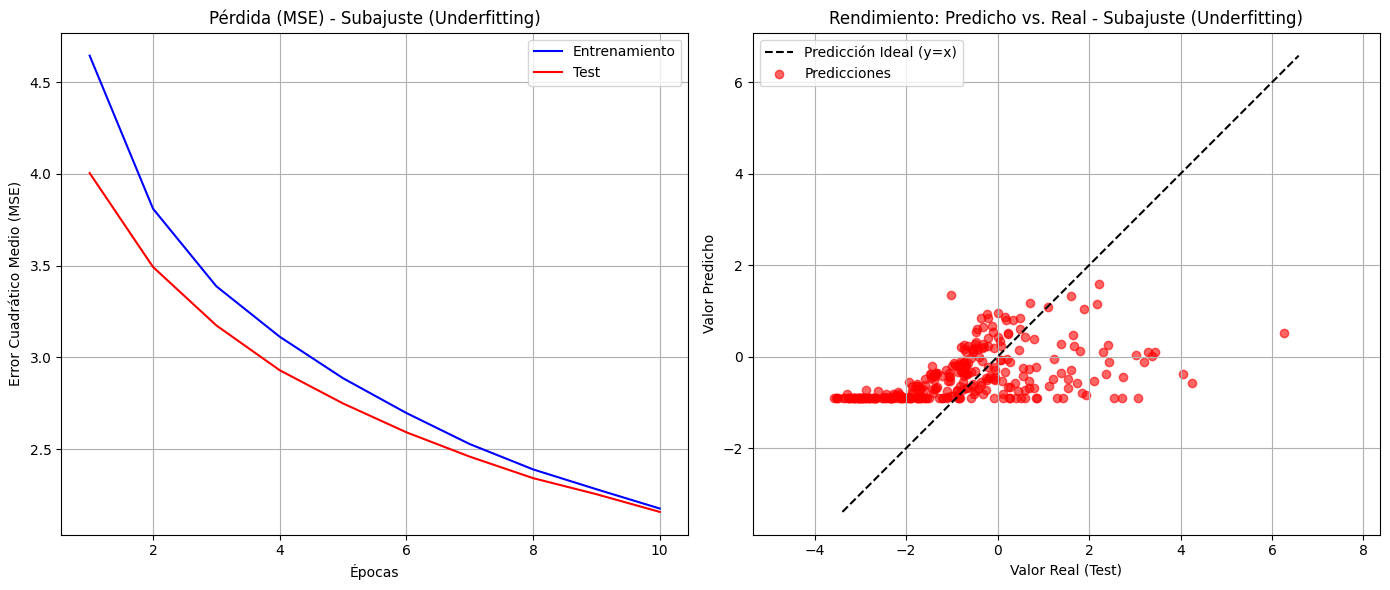

In [57]:
# ENTRENAMIENTO DEL MODELO UNDERFITTING -----------------

mlp_underfit=SimpleMLP(input_size=4, hidden_size=2)

print('\n--- INICIANDO ENTRENAMIENTO DE SUBAJUSTE ---')

results_underfit=train_and_evaluate(
    model=mlp_underfit,
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=10,
    lr=0.01,
    weight_decay=0.0,
    config_name='Subajuste (Underfitting)'
)

# 3. Grafico
plot_results_regresion('Subajuste (Underfitting)', *results_underfit)

**Explicación del grafico**

1. Grafico Curva de Pérdida MSE:
Podemos ver el error cuadratico medio en las 10 epocas del modelo subajustado

El modelo despues de la epoca 6 comienza a estancarse en un valor alto de 1.75.
Las curvas de entrenamiento y testeo estan muy juntas y al final terminan cruzandose siendo eltesteo el que mayor perdida final tiene.
Es simple y no logra capturar patrones complejos.

2. Grafico de Rendimiento:

Los puntos estan muy dispersos, mas formando una especie de nube, cuando lo ideal en una linea.

Modelo Overfitting


--- INICIANDO ENTRENAMIENTO DE SOBREAJUSTE ---
[Sobreajuste (Overfitting)] Epoch 10/100, Train MSE: 0.7207, Test MSE: 0.8036
[Sobreajuste (Overfitting)] Epoch 20/100, Train MSE: 0.4508, Test MSE: 0.5848
[Sobreajuste (Overfitting)] Epoch 30/100, Train MSE: 0.3712, Test MSE: 0.4949
[Sobreajuste (Overfitting)] Epoch 40/100, Train MSE: 0.3202, Test MSE: 0.4407
[Sobreajuste (Overfitting)] Epoch 50/100, Train MSE: 0.2663, Test MSE: 0.4222
[Sobreajuste (Overfitting)] Epoch 60/100, Train MSE: 0.2259, Test MSE: 0.3419
[Sobreajuste (Overfitting)] Epoch 70/100, Train MSE: 0.1869, Test MSE: 0.3046
[Sobreajuste (Overfitting)] Epoch 80/100, Train MSE: 0.1526, Test MSE: 0.2673
[Sobreajuste (Overfitting)] Epoch 90/100, Train MSE: 0.1292, Test MSE: 0.2383
[Sobreajuste (Overfitting)] Epoch 100/100, Train MSE: 0.1092, Test MSE: 0.2069


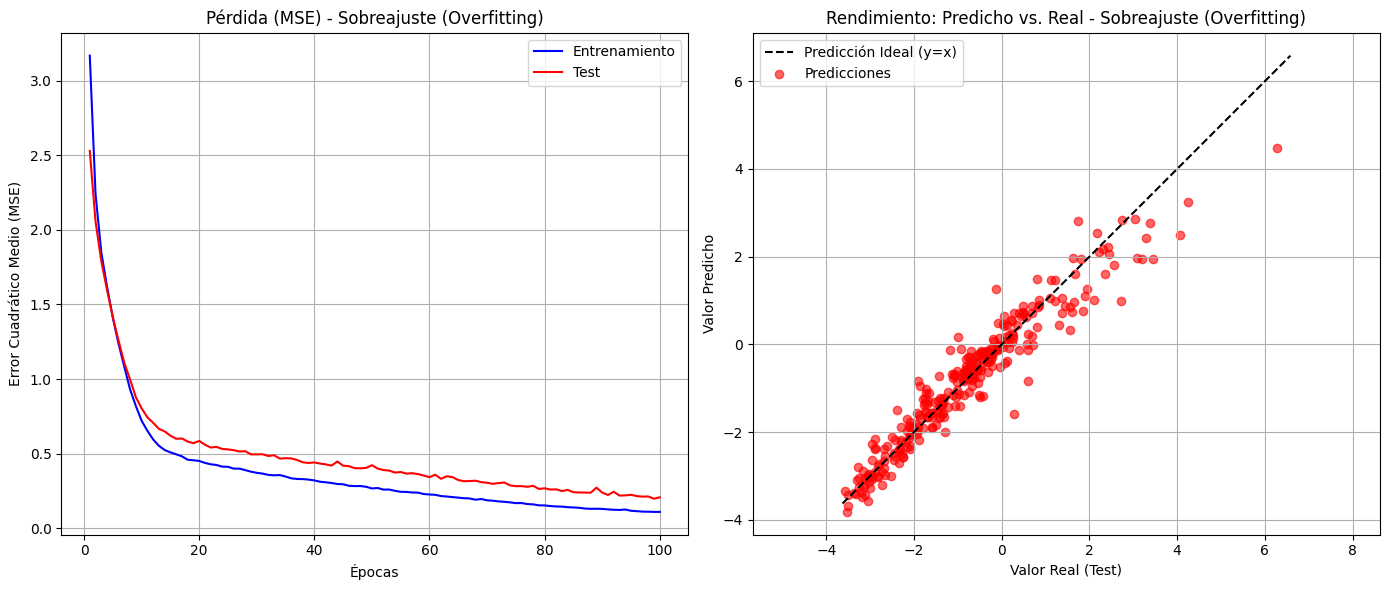

In [58]:
# ENTRENAMIENTO DEL MODELO OVERFITTING

mlp_overfit=SimpleMLP(input_size=4, hidden_size=256)
print('\n--- INICIANDO ENTRENAMIENTO DE SOBREAJUSTE ---')

# 1. Modelo de alta capacidad
results_overfit=train_and_evaluate(
    model=mlp_overfit,
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=100,
    lr=0.001,
    weight_decay=0.0,
    config_name='Sobreajuste (Overfitting)'
)

# Grafico:
plot_results_regresion('Sobreajuste (Overfitting)', *results_overfit)

**Explicación del grafico**

Este modelo tiene mucha capacidad y entreno por muchas epocas, lo que genera que este memorice.

1. Grafico Curva de Pérdida MSE:
 Entre las epocas 0 y 20 las curvas de aprendizaje y testeo bajan juntas. Despues de la epoca 20 la curva de entrenamiento sigue bajando (≈0.15) pero la de testeo se mantiene con mayor error (≈0.40).


2. Grafico de Rendimiento:
  Los puntos se agrupan al rededor de la linea real pero tiene varios puntos dispersos, esto es evidencia de memorizacion.

Modelo Aceptable


--- INICIANDO ENTRENAMIENTO DE MODDELO ACEPTABLE ---
[Aceptable] Epoch 5/50, Train MSE: 0.0994, Test MSE: 0.1999
[Aceptable] Epoch 10/50, Train MSE: 0.0893, Test MSE: 0.1769
[Aceptable] Epoch 15/50, Train MSE: 0.0809, Test MSE: 0.1702
[Aceptable] Epoch 20/50, Train MSE: 0.0741, Test MSE: 0.1619
[Aceptable] Epoch 25/50, Train MSE: 0.0707, Test MSE: 0.1523
[Aceptable] Epoch 30/50, Train MSE: 0.0653, Test MSE: 0.1426
[Aceptable] Epoch 35/50, Train MSE: 0.0639, Test MSE: 0.1473
[Aceptable] Epoch 40/50, Train MSE: 0.0626, Test MSE: 0.1569
[Aceptable] Epoch 45/50, Train MSE: 0.0575, Test MSE: 0.1422
[Aceptable] Epoch 50/50, Train MSE: 0.0532, Test MSE: 0.1399


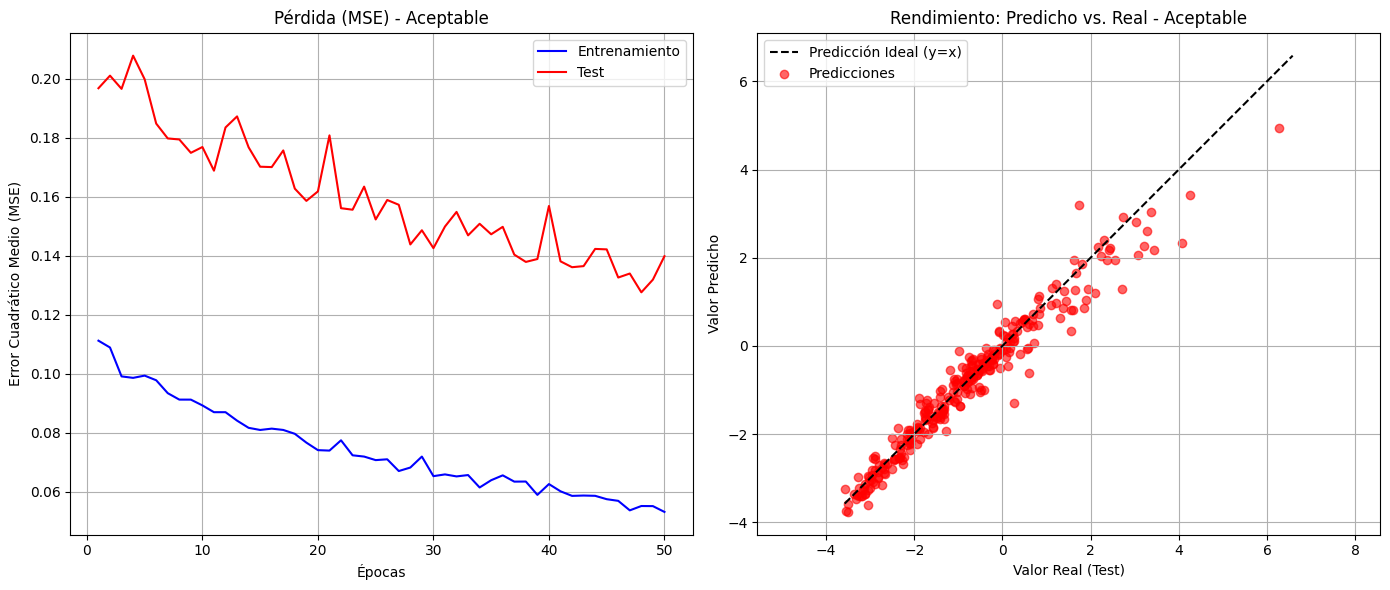

In [59]:
# ENTRENAMIENTO DEL MODELO ACEPTABLE

mlp_aceptable=SimpleMLP(input_size=4, hidden_size=20)
print('\n--- INICIANDO ENTRENAMIENTO DE MODDELO ACEPTABLE ---')

# 1. Modelo de alta capacidad
results_aceptable=train_and_evaluate(
    model=mlp_overfit,
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=50,
    lr=0.001,
    weight_decay=0.0,
    config_name='Aceptable'
)

# Grafico:
plot_results_regresion('Aceptable', *results_aceptable)

**Explicación del grafico**


1. Grafico Curva de Pérdida MSE:
  Las lineas de los dos modelos son mas cercanas entre si, tampoco hay mucha diferencia entre sus valores y ambos son bajos.

2. Grafico de Rendimiento:
  Los puntos estan  mas alineados que en el modelo anterior, sugiriendo mayor precision.
  


### **3. Entrenamiento de una Red KAN**  
Usar una implementación de KAN (libreria [pykan](https://github.com/KindXiaoming/pykan)).  

**Configuraciones a probar:**  
1. **Underfitting:**  
   - Red muy simple (ej: 1-2 neuronas por capa).  
   - Poca capacidad de aproximación.  

2. **Solución Aceptable:**  
   - Arquitectura equilibrada (ej: 4-5 neuronas por capa).  
   - Ajuste fino de hiperparámetros.  

3. **Overfitting:**  
   - Red muy profunda o con demasiadas neuronas.  
   - Entrenamiento prolongado sin early stopping.  

**Visualización:**  
- Graficar la función aprendida por KAN vs. los datos reales (en 2D si se proyecta una feature).  



Importacion


In [60]:
pip install git+https://github.com/KindXiaoming/pykan.git

  Cloning https://github.com/KindXiaoming/pykan.git to /tmp/pip-req-build-4ctz0a9_
  Running command git clone --filter=blob:none --quiet https://github.com/KindXiaoming/pykan.git /tmp/pip-req-build-4ctz0a9_
  Resolved https://github.com/KindXiaoming/pykan.git to commit ecde4ec3274d3bef1ad737479cf126aed38ab530
  Preparing metadata (setup.py) ... done


In [61]:
from kan import KAN

In [62]:
torch.manual_seed(123)
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

Entrenamiento y testeo red KAN

In [63]:
def train_kan(model, optimizer, criterion, X_train, y_train, X_test, y_test, epochs=20):
    train_losses, test_losses= [], []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output=model(X_train)
        loss=criterion(output, y_train)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
          test_output=model(X_test)
          test_loss=criterion(test_output, y_test)

        train_losses.append(loss.item())
        test_losses.append(test_loss.item())

        print(f'Epoch [{epoch+1}/{epochs}] - Loss Train: {loss.item():.4f} - Loss Test: {test_loss.item():.4f}')

    return train_losses, test_losses



Subajuste

In [64]:
kan_under=KAN(width=[4,2,1], grid=3).to(device)
optimizer_under=optim.Adam(kan_under.parameters(), lr=0.01)
criterion=nn.MSELoss()

checkpoint directory created: ./model
saving model version 0.0


Sobreajuste

In [65]:
kan_over=KAN(width=[4,52,52,1], grid=20).to(device)
optimizer_over=optim.Adam(kan_over.parameters(), lr=0.001)

checkpoint directory created: ./model
saving model version 0.0


Aceptable

In [66]:
kan_good=KAN(width=[4,8,1], grid=6).to(device)
optimizer_good=optim.Adam(kan_good.parameters(), lr=0.005)

checkpoint directory created: ./model
saving model version 0.0


Entrenamos cada modelo:

In [67]:
print("\n--- Entrenando KAN (Underfitting) ---")
train_under, test_under = train_kan(
    kan_under, optimizer_under, criterion,
    X_train, y_train, X_test, y_test, epochs=30
)



--- Entrenando KAN (Underfitting) ---
Epoch [1/30] - Loss Train: 3.4088 - Loss Test: 3.2830
Epoch [2/30] - Loss Train: 3.3741 - Loss Test: 3.2500
Epoch [3/30] - Loss Train: 3.3402 - Loss Test: 3.2172
Epoch [4/30] - Loss Train: 3.3065 - Loss Test: 3.1842
Epoch [5/30] - Loss Train: 3.2727 - Loss Test: 3.1508
Epoch [6/30] - Loss Train: 3.2385 - Loss Test: 3.1166
Epoch [7/30] - Loss Train: 3.2035 - Loss Test: 3.0813
Epoch [8/30] - Loss Train: 3.1675 - Loss Test: 3.0449
Epoch [9/30] - Loss Train: 3.1302 - Loss Test: 3.0069
Epoch [10/30] - Loss Train: 3.0913 - Loss Test: 2.9674
Epoch [11/30] - Loss Train: 3.0509 - Loss Test: 2.9262
Epoch [12/30] - Loss Train: 3.0086 - Loss Test: 2.8832
Epoch [13/30] - Loss Train: 2.9646 - Loss Test: 2.8385
Epoch [14/30] - Loss Train: 2.9187 - Loss Test: 2.7919
Epoch [15/30] - Loss Train: 2.8709 - Loss Test: 2.7436
Epoch [16/30] - Loss Train: 2.8213 - Loss Test: 2.6937
Epoch [17/30] - Loss Train: 2.7698 - Loss Test: 2.6420
Epoch [18/30] - Loss Train: 2.7167 

In [68]:
print("\n--- Entrenando KAN (Overfitting) ---")
train_over, test_over = train_kan(
    kan_over, optimizer_over, criterion,
    X_train, y_train, X_test, y_test, epochs=200
)



--- Entrenando KAN (Overfitting) ---
Epoch [1/200] - Loss Train: 3.3334 - Loss Test: 3.2167
Epoch [2/200] - Loss Train: 3.2827 - Loss Test: 3.1690
Epoch [3/200] - Loss Train: 3.2324 - Loss Test: 3.1214
Epoch [4/200] - Loss Train: 3.1821 - Loss Test: 3.0736
Epoch [5/200] - Loss Train: 3.1318 - Loss Test: 3.0257
Epoch [6/200] - Loss Train: 3.0813 - Loss Test: 2.9774
Epoch [7/200] - Loss Train: 3.0305 - Loss Test: 2.9289
Epoch [8/200] - Loss Train: 2.9794 - Loss Test: 2.8801
Epoch [9/200] - Loss Train: 2.9282 - Loss Test: 2.8310
Epoch [10/200] - Loss Train: 2.8766 - Loss Test: 2.7817
Epoch [11/200] - Loss Train: 2.8250 - Loss Test: 2.7323
Epoch [12/200] - Loss Train: 2.7732 - Loss Test: 2.6829
Epoch [13/200] - Loss Train: 2.7214 - Loss Test: 2.6335
Epoch [14/200] - Loss Train: 2.6696 - Loss Test: 2.5842
Epoch [15/200] - Loss Train: 2.6179 - Loss Test: 2.5351
Epoch [16/200] - Loss Train: 2.5664 - Loss Test: 2.4863
Epoch [17/200] - Loss Train: 2.5151 - Loss Test: 2.4378
Epoch [18/200] - Lo

In [76]:
print("\n--- Entrenando KAN (Aceptable) ---")
train_good, test_good = train_kan(
    kan_good, optimizer_good, criterion,
    X_train, y_train, X_test, y_test, epochs=50
)


--- Entrenando KAN (Aceptable) ---
Epoch [1/50] - Loss Train: 1.0747 - Loss Test: 0.9874
Epoch [2/50] - Loss Train: 1.0464 - Loss Test: 0.9595
Epoch [3/50] - Loss Train: 1.0197 - Loss Test: 0.9331
Epoch [4/50] - Loss Train: 0.9944 - Loss Test: 0.9084
Epoch [5/50] - Loss Train: 0.9705 - Loss Test: 0.8853
Epoch [6/50] - Loss Train: 0.9480 - Loss Test: 0.8637
Epoch [7/50] - Loss Train: 0.9268 - Loss Test: 0.8435
Epoch [8/50] - Loss Train: 0.9068 - Loss Test: 0.8246
Epoch [9/50] - Loss Train: 0.8880 - Loss Test: 0.8069
Epoch [10/50] - Loss Train: 0.8703 - Loss Test: 0.7903
Epoch [11/50] - Loss Train: 0.8535 - Loss Test: 0.7748
Epoch [12/50] - Loss Train: 0.8377 - Loss Test: 0.7601
Epoch [13/50] - Loss Train: 0.8226 - Loss Test: 0.7462
Epoch [14/50] - Loss Train: 0.8083 - Loss Test: 0.7329
Epoch [15/50] - Loss Train: 0.7945 - Loss Test: 0.7203
Epoch [16/50] - Loss Train: 0.7814 - Loss Test: 0.7082
Epoch [17/50] - Loss Train: 0.7688 - Loss Test: 0.6966
Epoch [18/50] - Loss Train: 0.7568 - L

Resultados finales del testeo de cada modelo:

In [77]:
def evaluate(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        pred = model(X_test)
        loss = nn.MSELoss()(pred, y_test)
    return loss.item()

print("\n--- Evaluación final ---")
print(f"Underfitting MSE: {evaluate(kan_under, X_test, y_test):.4f}")
print(f"Overfitting MSE: {evaluate(kan_over, X_test, y_test):.4f}")
print(f"Aceptable MSE: {evaluate(kan_good, X_test, y_test):.4f}")



--- Evaluación final ---
Underfitting MSE: 1.8938
Overfitting MSE: 0.5462
Aceptable MSE: 0.5160


Graficamos los resultados:

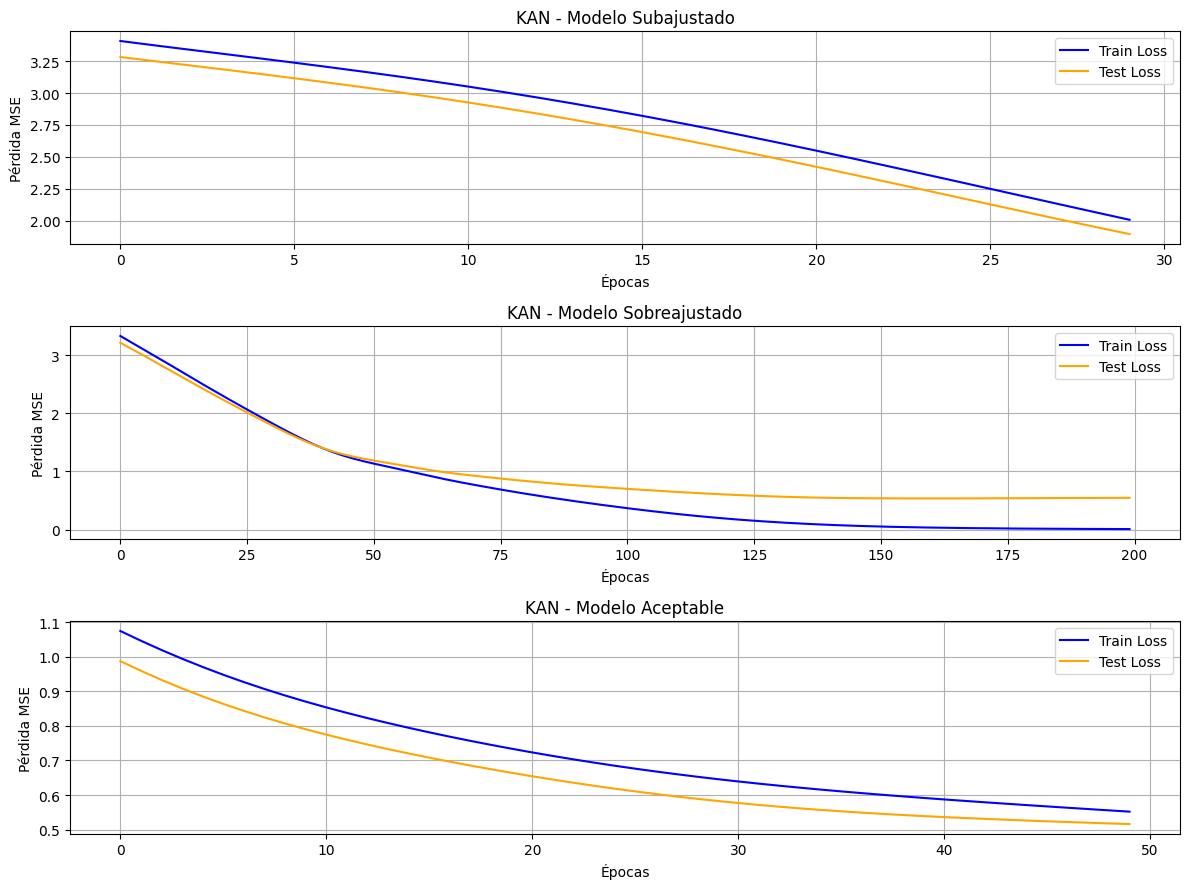

In [78]:
# --- Graficamos ---
plt.figure(figsize=(12, 9))

# Subajuste
plt.subplot(3, 1, 1)
plt.plot(train_under, label="Train Loss", color="blue")
plt.plot(test_under, label="Test Loss", color="orange")
plt.title("KAN - Modelo Subajustado")
plt.xlabel("Épocas")
plt.ylabel("Pérdida MSE")
plt.legend()
plt.grid(True)

# Sobreajuste
plt.subplot(3, 1, 2)
plt.plot(train_over, label="Train Loss", color="blue")
plt.plot(test_over, label="Test Loss", color="orange")
plt.title("KAN - Modelo Sobreajustado")
plt.xlabel("Épocas")
plt.ylabel("Pérdida MSE")
plt.legend()
plt.grid(True)

# Modelo aceptable
plt.subplot(3, 1, 3)
plt.plot(train_good, label="Train Loss", color="blue")
plt.plot(test_good, label="Test Loss", color="orange")
plt.title("KAN - Modelo Aceptable")
plt.xlabel("Épocas")
plt.ylabel("Pérdida MSE")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


**Conclusiones Red KAN**

En el caso del **subajuste** la arquitectura es muy simple [2 neuronas en la capa oculta=2 - grid bajo=3]
- **grid=** Granularidad de splines, se refiere a cuantos puntos de anclaje se utilizan para definir las funciones que actuan como conexiones en la red KAN (curvas).

La pérdida final en la época 30 es alta tanto para entrenamiento como para prueba (≈0.8), y ambas curvas están muy juntas. Esto demuestra que el modelo no tiene la capacidad suficiente para aprender los patrones de los datos, resultando en un train loss alto y un test loss igualmente alto.

En el caso del **sobreajuste** se diseño de forma mucho más compleja [con dos capas ocultas=52,52 - grid alto=180]. Esto le permite memorizar facilmente, jugando con el numero de epochs pude notar que el test loss al cruzarse por encima de la curva de train loss esta solo aumenta, mientras que el train loss se estanca en la perdida minima.

En el caso del modelo **aceptable** opte por una estructura equilibrada, esta ofrece una capacidad moderada [8 neuronas en la capa oculta- grid=4]. Las dos curvas disminuyen establemente y al estabilizarse en un numero bajo no meustran una distancia alta entre ellas.

Visualizaciones

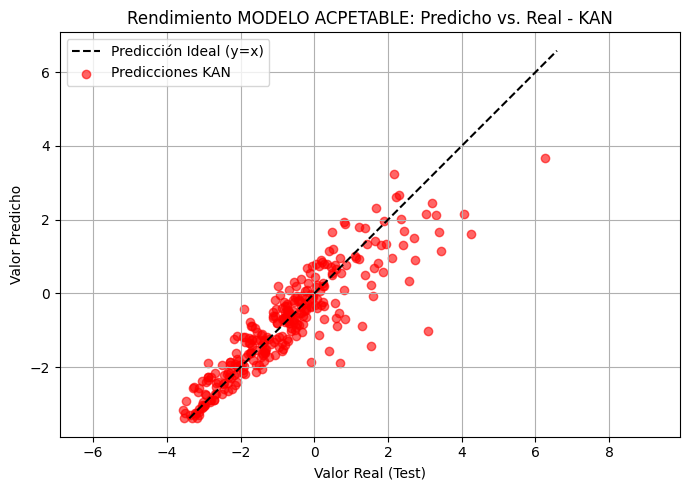

In [83]:
kan_good.eval()
with torch.no_grad():
  final_test_preds=kan_good(X_test).squeeze().tolist()
  final_test_labels=y_test.squeeze().tolist()

  plt.figure(figsize=(7, 5))
  max_val = max(max(final_test_labels), max(final_test_preds)) * 1.05
  min_val = min(min(final_test_labels), min(final_test_preds)) * 0.95
  plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='Predicción Ideal (y=x)')
  plt.scatter(final_test_labels, final_test_preds, color='red', alpha=0.6, label='Predicciones KAN')
  plt.title(f'Rendimiento MODELO ACPETABLE: Predicho vs. Real - KAN')
  plt.xlabel('Valor Real (Test)')
  plt.ylabel('Valor Predicho')
  plt.legend()
  plt.grid(True)
  plt.axis('equal')

  plt.tight_layout()
  plt.show()

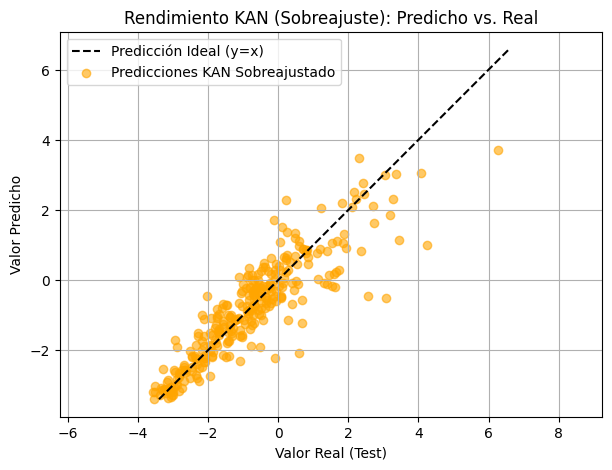

In [84]:
kan_over.eval()

with torch.no_grad():
   final_test_preds_over = kan_over(X_test).squeeze().tolist()
   final_test_labels_over = y_test.squeeze().tolist()

plt.figure(figsize=(7, 5))

max_val = max(max(final_test_labels_over), max(final_test_preds_over)) * 1.05
min_val = min(min(final_test_labels_over), min(final_test_preds_over)) * 0.95
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='Predicción Ideal (y=x)')

plt.scatter(final_test_labels_over, final_test_preds_over, color='orange', alpha=0.6, label='Predicciones KAN Sobreajustado')

plt.title('Rendimiento KAN (Sobreajuste): Predicho vs. Real')
plt.xlabel('Valor Real (Test)')
plt.ylabel('Valor Predicho')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

#### **4. Conclusiones y Análisis**  
- Comparar **MLP vs KAN** en términos de:  
  - Capacidad de aproximación.  
  - Sensibilidad al overfitting/underfitting.  
  - Interpretabilidad (KAN permite visualizar funciones base).  
- Discutir:  
  - ¿Cuál modelo es más flexible?  
  - ¿En qué casos conviene usar KAN?  



### Comparación de MLP y KAN

####**Capacidad de aproximacion:**
- **La red MLP** utiliza una **formula rigida** y los apila varias veces para llegar a aproximar una curva. Por esto necesita ser mas grande para lograr dibujar esta curva con presicion, como si usaras muchísimos segmentos de líneas rectas para dibujar un círculo.

- **La red KAN** usa una serie de splines (curvas suaves), por lo que necesita menos tamaño para ser igual de precisa.

####**Sensibilidad al Overfitting/Underfitting**
- La **red MLP** es más sensible a la complejidad. Tiende a sobreajustar si es muy grande y a subajustar si es muy pequeña.

- La **red KAN** tiende a suavizar las curvas, puede memorizar mas facilmente si le damos muchos puntos de control (grid).

####**Interpretabilidad**
-   **MLP** se menciona como una caja negra. Es dificil entender que representa cada neurona o capa. Googleando el porque puedo decir que:

    - _En un MLP la relación entre una variable de entrada y la salida no está definida por una sola función visible, sino por una composición secuencial de funciones.
    
       El resultado final, es una función extremadamente compleja que depende de la interacción combinada de muchisimas de estas operaciones anidadas. Es matemáticamente imposible para un humano deshacer esta composición para decir: **"Si x3 aumenta en 1, el impacto en y es esta función simple".**_que en definitiva eso es para nosotros enterpretar.

- **Las redes KAN** dibujan la curva exacta que usaron para hacer la predicion (seria el spline). Esto nos permite ver la relacion exacta que el modelo descubrio.

### ¿Cuál modelo es más flexible?

Los dos modelos pueden generar una estructura flexible pero la RED KAN tiene la ventaja de su flexibilidad funcional gracias a los spline de los que hablamos. Esto le permite un alto rendimiento sin tener que generar una estructura mas grande y compleja.

### - ¿En qué casos conviene usar KAN?

Elegir entre una red KAN  y una red MLP **depende principalmente del tipo de problema y de los datos con los que se trabaja.**

Las KAN resultan convenientes cuando se trata de datos estructurados como señales, formas de onda o gráficos, y cuando se busca aprendizaje continuo o interpretabilidad, ya que cada conexión utiliza funciones splines visibles que permiten entender mejor cómo la red aprende. Estas funciones suaves también pueden ofrecer buena generalización con pocos datos y menor riesgo de sobreajuste en conjuntos pequeños o ruidosos.

Sin embargo, las KAN requieren mayor costo computacional y tiempos de entrenamiento más largos, además de ser una tecnología todavía nueva, con menos herramientas y optimizaciones disponibles que las MLP.

Por eso, las MLP siguen siendo la mejor opción para problemas complejos o de gran escala, como los de Big Data, donde se necesita eficiencia, velocidad y soporte consolidado en las librerías de aprendizaje profundo.

En síntesis, las KAN no reemplazan a las MLP, sino que las complementan, ofreciendo ventajas en contextos especializados (especialmente en matemática, física o análisis de funciones) y cuando la interpretabilidad y el rendimiento con pocos datos son prioridades.

## **5- Referencias**

Debe citar y mencionar todas las herramientas utilizadas.

Si utiliza una IA (GPT), especifique los prompts utilizados y salidas.



Material KAN que nos proporciono la profesora


Para dar mi conclusion de cuando usar KAN, le explique a mi manera cuando era conveniente usarlas y cuando no, ayudandome de a investigacion que hice en google y esta pagina que encontre tambien en google, adjunto el link. Teniendo en cuenta todo lo que le explique me genero un teto que ajuste un poco y fue mi respuesta a esta pregunta.

https://hackernoon.com/lang/es/comparando-kolmogorov-arnold-network-kan-y-perceptrones-multicapa-mlps

promt: a que se refiere con 'Capacidad de Aproximación' y 'Interpretabilidad' hbalando de redes MLP y KAN

Excelente pregunta 🔥 — esas dos expresiones ("capacidad de aproximación" e "interpretabilidad") son conceptos clave cuando se comparan modelos como las redes MLP (Multilayer Perceptron) y las KAN (Kolmogorov-Arnold Networks).
Te lo explico en lenguaje claro 👇

🧠 1. Capacidad de Aproximación

👉 Se refiere a qué tan bien un modelo puede aprender o representar funciones complejas (es decir, relaciones entre variables de entrada y salida).

En MLP:

Las redes neuronales tradicionales (MLP) son aproximadores universales:
con suficientes capas y neuronas, pueden aprender cualquier función (lineal o no lineal).

Sin embargo, para lograr esa precisión, muchas veces se necesita:

gran cantidad de datos,

entrenamiento largo,

y una buena elección de hiperparámetros (capas, neuronas, etc.).

📉 Si tiene pocas neuronas → subajusta (underfitting).
📈 Si tiene demasiadas → sobreajusta (overfitting).

En KAN:

Las KAN también tienen alta capacidad de aproximación, pero con una estructura diferente:

En lugar de usar solo combinaciones lineales + activaciones, utilizan funciones tipo spline o representaciones funcionales adaptativas.

Eso les permite aprender funciones complejas con menos parámetros que una MLP.

En muchos casos, una KAN puede alcanzar la misma precisión con una arquitectura más pequeña o con entrenamiento más estable.


👁️ 2. Interpretabilidad

👉 Se refiere a qué tan fácil es entender lo que el modelo “aprendió” o cómo llega a sus predicciones.

En MLP:

Las MLP son cajas negras:
es difícil saber qué representa cada neurona o capa.

No es sencillo interpretar qué partes del modelo corresponden a ciertas relaciones de las variables.

🔍 Ejemplo: sabés que la red predice bien, pero no podés explicar fácilmente por qué.

En KAN:

Las KAN son más interpretables, porque su estructura funcional representa directamente relaciones matemáticas entre las variables.
Por ejemplo:

Cada conexión puede aproximar una función explícita (como una curva spline),

y podés visualizar o analizar esas funciones.

Esto hace que sea más fácil ver cómo cada entrada afecta a la salida.

📊 Es decir, las KAN permiten “abrir la caja negra” un poco más y entender cómo el modelo construye su resultado.